# Steam Hours Capestone

## Description
The gaming industry now makes more money than the film and music industry combined. We have decided to look into what makes a customer play games for large amounts of time. We will look into what features if any contribute to the number of gameplay hours and create a machine learning model to estimate the hours played for certain types of games. With the model we will be able to predict the value of a game.

## Goal
* Discover drivers of hours played from database
* Use drivers to develop a machine learning model to determine value of the product
* This information could be used to further our understanding of which elements contribute to or detract from a person's tendency spend time on a game

## Initial Thoughts
We believe that Multiplayer games with a competitive element, such as battle royales, like Fortnite, have the highest game hours. We believe that the games with the least amount of hours are horror genre games.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
np.random.seed(123)

import warnings
warnings.filterwarnings("ignore")
import Wrangle as w
import explore as e
import modeling as m

from scipy import stats
import re

# Acquire
* Data acquired from SteamSpy api


* Requested many features of 3000 games


* Acquiring genres for games required a loop for 3000 requests on each game


* The dataset contained 3000 rows and 21 columns before cleaning


* Each row represents a game in the steam dataset


* Each column represent a feature of the game


* Data appended and turned into final_steamspy_3000_games.csv

In [2]:
df = w.get_clean_steamspy_data()

# Prepare
Prepare Actions:
* Convert avg minutes played per game to avg hours
* Create bins for avg hours played to make target categorical variable
* Create bins for initial release price in order to make it a categorical feature
* Hot encode publishers and developers and only bring in those that have pushed out a game in our data that has made it in the top 5 % of games while having over 1,000,000 copies sold
* Hot encode all genres
* dropped score_rank column as it was all nulls
* dropped userscore as it was all 0's
* dropped all remaining nulls which only resulted in about 100 rows lost.

## Data Dictionary


| Feature | Definition |
|:--------|:-----------|
|name| The title of the game|
|developer| The name of the company that developed the game|
|publisher| The name of the compnay that published the game|
|positive| Number of positive reviews|
|negative| Number of negative reviews|
|average_forever| Average hours played since game was published|
|average_2weeks| Average hours played in past two weeks|
|median_forever| The median hours played since game was published|
|median_2weeks| The median hours played in past two weeks|
|ccu| The number of concurrent users|

In [3]:
# acquiring the dataframe and looking at it
df = pd.read_csv('final_steamspy_3000_games.csv', index_col = 0)
df.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,appid.1,tags,genre
0,570,Dota 2,Valve,Valve,NaN,1587210,330303,0,"200,000,000 .. 500,000,000",40447,1560,976,1084,0,0,0,543171,570,"['Free to Play', 'MOBA', 'Multiplayer', 'Strat...","Action, Free to Play, Strategy"
1,730,Counter-Strike: Global Offensive,"Valve, Hidden Path Entertainment",Valve,NaN,6084096,801021,0,"50,000,000 .. 100,000,000",29608,771,6381,271,0,0,0,938203,730,"['FPS', 'Shooter', 'Multiplayer', 'Competitive...","Action, Free to Play"
2,578080,PUBG: BATTLEGROUNDS,"KRAFTON, Inc.","KRAFTON, Inc.",NaN,1214011,917768,0,"50,000,000 .. 100,000,000",22856,648,6688,189,0,0,0,324204,578080,"['Survival', 'Shooter', 'Battle Royale', 'Mult...","Action, Adventure, Free to Play, Massively Mul..."
3,1063730,New World,Amazon Games,Amazon Games,NaN,174544,75536,0,"50,000,000 .. 100,000,000",8257,1454,3567,1311,3999,3999,0,30922,1063730,"['Massively Multiplayer', 'Open World', 'MMORP...","Action, Adventure, Massively Multiplayer, RPG"
4,1172470,Apex Legends,Respawn Entertainment,Electronic Arts,NaN,483639,93045,0,"50,000,000 .. 100,000,000",6705,746,605,362,0,0,0,292023,1172470,"['Free to Play', 'Multiplayer', 'Battle Royale...","Action, Adventure, Free to Play"


In [4]:
# clean and prepare the dataframe
df = w.clean_steamspy(df)

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# split the data into train, validate, and test
train, validate, test = w.my_train_test_split(df)

### A brief look at the data

In [7]:
train.head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,appid.1,tags,genre,binned_hours_explore,binned_hours,binned_release_price,free_to_play,budget_games,full_price,Publisher_,Publisher_Valve,Publisher_KRAFTON,Publisher__Inc.,Publisher_Rockstar_Games,Publisher_Facepunch_Studios,Publisher_Ubisoft,Publisher_Psyonix_LLC,Publisher_Bohemia_Interactive,Publisher_SEGA,Publisher__Feral_Interactive_(Mac),Publisher__Feral_Interactive_(Linux),Publisher_Paradox_Interactive,Publisher_Square_Enix,Publisher_Ludeon_Studios,Publisher_Xbox_Game_Studios,Publisher_Playsaurus,Publisher_Giants_Software,Publisher_Leppsoft,Publisher_Laminar_Research,Developer_,Developer_Valve,Developer__Hidden_Path_Entertainment,Developer_KRAFTON,Developer__Inc.,Developer_Rockstar_North,Developer_Facepunch_Studios,Developer_Ubisoft_Montreal,Developer_Psyonix_LLC,Developer_Bohemia_Interactive,Developer_CREATIVE_ASSEMBLY,Developer__Feral_Interactive_(Mac),Developer__Feral_Interactive_(Linux),Developer_Paradox_Development_Studio,Developer_Sports_Interactive,Developer_Square_Enix,Developer__Paradox_Tinto,Developer_Ludeon_Studios,Developer_Microsoft_Game_Studios,Developer_Orteil,Developer__DashNet,Developer_Giants_Software,Developer_Leppsoft,Developer_Laminar_Research,Genre_Action,Genre_ Free to Play,Genre_ Strategy,Genre_ Adventure,Genre_ Massively Multiplayer,Genre_ RPG,Genre_ Casual,Genre_ Indie,Genre_Indie,Genre_ Simulation,Genre_Casual,Genre_ Animation & Modeling,Genre_ Design & Illustration,Genre_ Photo Editing,Genre_ Utilities,Genre_ Early Access,Genre_ Sports,Genre_RPG,Genre_Adventure,Genre_ Racing,Genre_Strategy,Genre_Simulation,Genre_Free to Play,Genre_Massively Multiplayer,Genre_nan,Genre_Animation & Modeling,Genre_ Video Production,Genre_Racing,Genre_Audio Production,Genre_Utilities,Genre_Sports,Genre_Software Training,Genre_ Game Development,Genre_ Audio Production,Genre_ Web Publishing,Genre_Design & Illustration,Genre_Game Development,Genre_ Movie,Genre_ Education,Genre_ Software Training,Genre_Early Access
2611,633460,Tannenberg,"M2H,_Blackmill_Games",M2H,7498,1186,"200,000 .. 500,000",5.983333,0.000000,5.366667,0.000000,1999,1999,0,55,633460,"['Gore', 'Team-Based', 'World War I', 'Shooter...","Action, Indie, Simulation",moderately_played,moderately_played,free_to_play,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2328,420290,Blackwake,Mastfire_Studios_Pty_Ltd,Mastfire_Studios_Pty_Ltd,19780,4306,"200,000 .. 500,000",8.766667,6.533333,2.050000,6.533333,499,499,0,28,420290,"['Pirates', 'Multiplayer', 'Naval Combat', 'Na...","Action, Casual, Indie, Strategy",moderately_played,moderately_played,free_to_play,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,True,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2147,1209490,Exit the Gungeon,"Dodge_Roll,_Singlecore",Devolver_Digital,2289,642,"200,000 .. 500,000",6.783333,0.000000,5.133333,0.000000,999,999,0,12,1209490,"['Action', 'Indie', 'Adventure', 'Arcade', 'Bu...","Action, Adventure, Indie",moderately_played,moderately_played,free_to_play,True,

### A summary of the data

In [8]:
train.describe()

,appid,positive,negative,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,appid.1
count,1.318000e+03,1.318000e+03,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1.318000e+03
mean,4.792700e+05,2.550141e+04,3222.742033,21.800569,3.037064,10.390680,3.287671,1599.533384,1954.740516,16.245068,1874.160850,4.792700e+05
std,4.049339e+05,7.615408e+04,10227.674056,42.124449,8.855275,15.554764,10.085776,1306.021236,1371.180816,30.356448,8726.699295,4.049339e+05
min,1.000000e+01,0.000000e+00,0.000000,0.216667,0.000000,0.066667,0.000000,28.000000,99.000000,0.000000,0.000000,1.000000e+01
25%,2.271500e+05,2.871250e+03,413.000000,4.700000,0.000000,3.120833,0.000000,599.000000,999.000000,0.000000,19.000000,2.271500e+05
50%,3.668500e+05,7.203500e+03,1013.500000,9.450000,0.000000,5.341667,0.000000,1449.000000,1799.000000,0.000000,96.000000,3.668500e+05
75%,6.379650e+05,1.824475e+04,2574.250000,21.387500,2.116667,11.412500,2.229167,1999.000000,2499.000000,0.000000,513.250000,6.379650e+05
max,1.987080e+06,1.274695e+06,215866.000000,679.750000,154.450000,183.966667,154.450000,9999.000000,9999.000000,90.000000,147780.000000,1.987080e+06


# Explore

## Does the initial price affect the hours played?

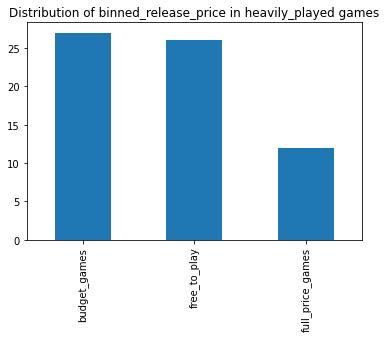

In [9]:
e.initial_price(train)

In [10]:
e.get_chi_initialprice(train)

chi^2 = 48.1807
p     = 0.0000


## Does the Developer matter?

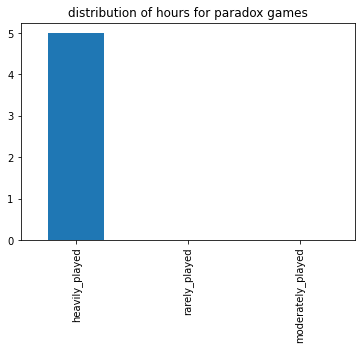

In [11]:
e.developer_visual(train)

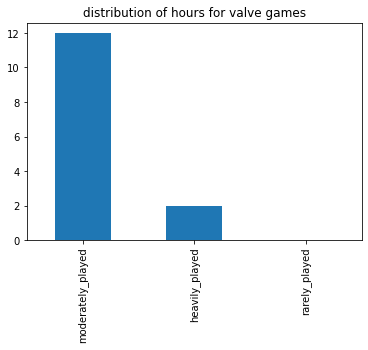

In [12]:
e.supporting_viz(train)

In [13]:
e.get_chi_valve(train)

chi^2 = 2.9182
p     = 0.2324


## Does the Publisher matter?

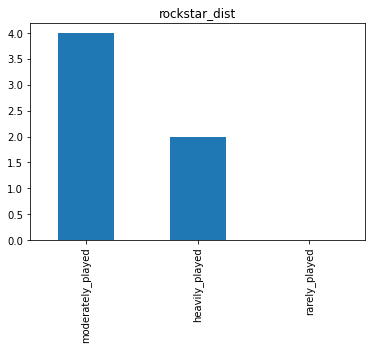

In [14]:
e.publisher_visual(train)

In [15]:
e.get_chi_publisher(train)

chi^2 = 10.4416
p     = 0.0054


In [16]:
e.get_chi_discount(train)

chi^2 = 28963.2900
p     = 0.2888


# Does the genre determine hours?

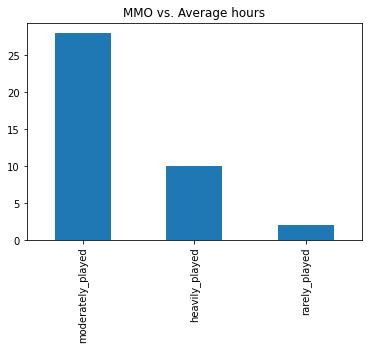

In [17]:
e.MMO_visual(train)

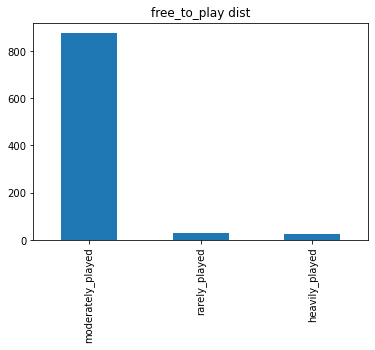

In [18]:
e.free_to_play(train)

# Exploration Summary
* The Developer matters to hours of gameplay
* The discount doesn't really matter
* Initial Price was found to be a driver of hours of gameplay

## Features moving forward
* Developer
* Initial Price
* Genre
* Publisher

# Modeling
* We will use accuracy as the evalutaion metric
* 80% will be the baseline
* Evaluation of models developed using four different model types and various hyperparameter configurations
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test data

In [19]:
# Prep data for modeling
train, validate, test = m.prep_for_model(train, validate, test)
x_train, y_train, x_validate, y_validate, x_test, y_test = m.isolate_target(train,validate,test)

scores, depth_list, c_val_list = m.initialize_models()

## Decision Tree

In [20]:
# get Decision Tree results
scores = m.get_decision_tree_results(x_train, y_train, x_validate, y_validate, depth_list, scores)
scores

Best parameters per algorithm:
----------------------------------------------------
Decision Tree Parameters:  {'max_depth': 3}
           heavily_played  moderately_played  rarely_played  accuracy  \
precision        0.333333           0.938215            0.0  0.934091   
recall           0.058824           0.995146            0.0  0.934091   
f1-score         0.100000           0.965842            0.0  0.934091   
support         17.000000         412.000000           11.0  0.934091   

            macro avg  weighted avg  
precision    0.423849      0.891389  
recall       0.351323      0.934091  
f1-score     0.355281      0.908243  
support    440.000000    440.000000  


,model_name,train_score,validate_score,score_difference
0,Decision Tree,0.933991,0.934091,-0.0001


## Random Forest

In [21]:
# get Random Forest results
scores = m.get_random_forest_results(x_train, y_train, x_validate, y_validate, depth_list, scores)
scores

Best parameters per algorithm:
----------------------------------------------------
Random Forest Parameters:  {'max_depth': 11}
           heavily_played  moderately_played  rarely_played  accuracy  \
precision        0.400000           0.940230            0.0  0.934091   
recall           0.117647           0.992718            0.0  0.934091   
f1-score         0.181818           0.965762            0.0  0.934091   
support         17.000000         412.000000           11.0  0.934091   

            macro avg  weighted avg  
precision    0.446743      0.895852  
recall       0.370122      0.934091  
f1-score     0.382527      0.911329  
support    440.000000    440.000000  


,model_name,train_score,validate_score,score_difference
0,Decision Tree,0.933991,0.934091,-0.000100
1,Random Forest,0.950683,0.934091,0.016592


## Logistic Regression

In [22]:
# get Logistic Regression results
scores = m.get_log_reg_results(x_train, y_train, x_validate, y_validate, c_val_list, scores)
scores

Best parameters per algorithm:
----------------------------------------------------
LR Parameters:  {'C': 0.55}
           heavily_played  moderately_played  rarely_played  accuracy  \
precision        1.000000           0.938497            0.0  0.938636   
recall           0.058824           1.000000            0.0  0.938636   
f1-score         0.111111           0.968273            0.0  0.938636   
support         17.000000         412.000000           11.0  0.938636   

            macro avg  weighted avg  
precision    0.646166      0.917410  
recall       0.352941      0.938636  
f1-score     0.359795      0.910948  
support    440.000000    440.000000  


,model_name,train_score,validate_score,score_difference
0,Decision Tree,0.933991,0.934091,-0.000100
1,Random Forest,0.950683,0.934091,0.016592
2,LR,0.931715,0.938636,-0.006922


## KNN

In [23]:
# get KNN results
scores = m.get_knn_results(x_train, y_train, x_validate, y_validate, scores)
scores

Best parameters per algorithm:
----------------------------------------------------
KNN Parameters:  {'n_neighbors': 5}
           heavily_played  moderately_played  rarely_played  accuracy  \
precision        1.000000           0.944954            0.0  0.945455   
recall           0.235294           1.000000            0.0  0.945455   
f1-score         0.380952           0.971698            0.0  0.945455   
support         17.000000         412.000000           11.0  0.945455   

            macro avg  weighted avg  
precision    0.648318      0.923457  
recall       0.411765      0.945455  
f1-score     0.450883      0.924581  
support    440.000000    440.000000  


,model_name,train_score,validate_score,score_difference
0,Decision Tree,0.933991,0.934091,-0.000100
1,Random Forest,0.950683,0.934091,0.016592
2,LR,0.931715,0.938636,-0.006922
3,KNN,0.935508,0.945455,-0.009946


## Comparing Models
* KNN was our most accurate model overall and ties for best precision on target class
* Logreg was close second
* Decision tree and random forest had very poor performance with our data.

# ...On Test

In [24]:
# get test results for final model
test_score = m.get_knn_test(x_train, y_train, x_test, y_test)
test_score

Best parameters per algorithm:
----------------------------------------------------
KNN Parameters:  {'n_neighbors': 5}
           heavily_played  moderately_played  rarely_played  accuracy  \
precision        0.500000           0.924658            0.0  0.922727   
recall           0.050000           0.997537            0.0  0.922727   
f1-score         0.090909           0.959716            0.0  0.922727   
support         20.000000         406.000000           14.0  0.922727   

            macro avg  weighted avg  
precision    0.474886      0.875934  
recall       0.349179      0.922727  
f1-score     0.350208      0.889688  
support    440.000000    440.000000  


,model_name,train_score,test_score,score_difference
0,KNN,0.935508,0.922727,0.012781


## Modeling Summary
* We were able to make 2 models that validated above baseline and gave us perfect precision on our target class
* our best model flopped on test and dropped 1% below our baseline
* we are moving forward with our KNN model

## conclusions

* Developer: Valve showed significantly high volume of heavily played games within their portfolio
* Publisher: Rockstar showed significantly high volume of heavily played games within their portfolio
* Price: Full price games showed significantly low volume of games within most played games (could be due to no paywall barrier.)
* Genre: Massively Multiplayer games showed significantly high volume of games within most played games.



## Recomendations

* Do not use our model yet as there is more work to be done in improving its ability to determine whether games will be havily played.

## Next Steps

* Change the way we are using grid search in order to optimize modeling hyperparameters for predicting our target class as opposed to highest overall accuracy.
* Acquire the release dates for games.
* Explore the platform used for games to see its effect on avg  hours played
* Acquire system requirements for games to see its effect on avg hours played
* Do more exploration on developers to determine whether or not they are productive to our model.
